# Tutorial: You can't put a label on me! Actually - please do.

## Creating optical water types from hyperspectral PACE data

Optical water type classification is a useful mechanism to isolate distinct reflectance signatures and track them over time and space. In another tutorial, we utilized the Apparent Visible Wavelength (AVW) to do something similar, but OWT classification uses a different approach, and tells us something a little different as well. Here, we are focusing more on using a priori knowledge of spectral reflectance, and using that as a reference point to find the closest match to the shape of our reflectance observed from satellites. The key advantage here is that we can put our data into a rigid and consistent classification system that clearly demarks areas with specific optical features. It's like being on a kitchy tour group and having everyone wear matching bright t-shirts so you can find one another... sort of. 

Our astute NOAA colleague Jianwei Wei, gatherred a large database of in situ and simualted hyperspectral refelctance data, and did some k-means clustering magic to come up with 23 distinct optical water classes. Check it out in [Wei et al. (2022)](https://doi.org/10.1016/j.rse.2022.113233). We're going to load those 23 distinct hyperspectral shapes, and then calculate the cosine distance between every spectra in our satellite image against all 23 of these shapes. The reflectance "shape" that produces the lowest cosine distance indicates 1 of those 23 shapes that is most similar to your satellite pixel. We assign each water class a different number and voila! - We have a mapped image putting our spectra into distinct optical water type classifications.  

Let's dive in and mess around with some spectra then. By the end of this tutorial, you will have:

> 1. Calculated the cosine distance between a spectral reference library against PACE data
> 2. Assigned Optical Water Types (OWT) from PACE data and made a map
> 3. Compared PACE spectra against the reference OWT spectra

## *Are you ready?*

## Let's go get some data first

Going the NASA Earth data route to get the full reflectance spectra. Let's subset a region around U.S. side of the North Atlantic ocean.

In [1]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  ryan.vandermeulen@noaa.gov
Enter your Earthdata password:  ········


In [2]:
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = ("2024-09-01", "2024-09-30"),
    granule_name="*.MO.*.0p1deg.*"
)

In [15]:
# Create a fileset
fileset = earthaccess.open(results);

# ---- Load Libraries ----
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
import pandas as pd

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])

# Extract hyperspectral Rrs
rrs_array = dataset['Rrs']  # shape: (wavelength, lat, lon)
wavelengths = rrs_array['wavelength'].values  # should be in nm

# ---- Spatial Subset (optional) ----
lat_bounds = slice(46, 35)
lon_bounds = slice(-78, -63)
rrs_subset = rrs_array.sel(lat=lat_bounds, lon=lon_bounds)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## Let's open it up!

Let's bring in our 23 reference spectra and match those to the PACE wavelengths. Then make the cosine distance calculation to find the closest match.

In [19]:
# --- Load reference spectra ---
nRrs_ref = pd.read_csv('Hyperspectral_nRrs.csv', index_col=0)

# Match satellite and reference wavelengths
sat_wavelengths_str = [str(int(w)) for w in wavelengths]
ref_columns = nRrs_ref.columns
common_wavelengths = sorted(set(sat_wavelengths_str).intersection(ref_columns), key=int)
print(f"Using {len(common_wavelengths)} common wavelengths: {common_wavelengths}")

# Extract matched reference spectra
ref = nRrs_ref[common_wavelengths].values

# Subset satellite reflectance to common wavelengths
common_wavelengths_float = [float(w) for w in common_wavelengths]
rrs_subset_common = rrs_subset.sel(wavelength=common_wavelengths_float)

# Normalize satellite data
norm = np.sqrt((rrs_subset_common ** 2).sum(dim='wavelength'))
rrs_norm = rrs_subset_common / norm

# Normalize reference spectra
ref_norm = ref / np.linalg.norm(ref, axis=1, keepdims=True)

# Flatten satellite data
rrs_flat = rrs_norm.stack(pix=('lat', 'lon')).transpose('pix', 'wavelength').values

# Compute cosine distance
dot_products = np.dot(rrs_flat, ref_norm.T)
cosine_distances = 1 - dot_products

# Assign class IDs
class_ids = np.argmin(cosine_distances, axis=1) + 1

# Reshape to 2D map
lat_dim, lon_dim = rrs_norm.sizes['lat'], rrs_norm.sizes['lon']
class_map = xr.DataArray(
    class_ids.reshape(lat_dim, lon_dim),
    dims=('lat', 'lon'),
    coords={'lat': rrs_norm['lat'], 'lon': rrs_norm['lon']},
    name='water_class'
)

Using 135 common wavelengths: ['403', '405', '408', '410', '413', '415', '418', '420', '422', '425', '427', '430', '432', '435', '437', '440', '442', '445', '447', '450', '452', '455', '457', '460', '462', '465', '467', '470', '472', '475', '477', '480', '482', '485', '487', '490', '492', '495', '497', '500', '502', '505', '507', '510', '512', '515', '517', '520', '522', '525', '527', '530', '532', '535', '537', '540', '542', '545', '547', '550', '553', '555', '558', '560', '563', '565', '568', '570', '573', '575', '578', '580', '583', '586', '588', '613', '615', '618', '620', '623', '625', '627', '630', '632', '635', '637', '640', '641', '642', '643', '645', '646', '647', '648', '650', '651', '652', '653', '655', '656', '657', '658', '660', '661', '662', '663', '665', '666', '667', '668', '670', '671', '672', '673', '675', '676', '677', '678', '679', '681', '682', '683', '684', '686', '687', '688', '689', '691', '692', '693', '694', '696', '697', '698', '699']


## Mappy time

Now, let's make a map of the optical water type for our single monthly image

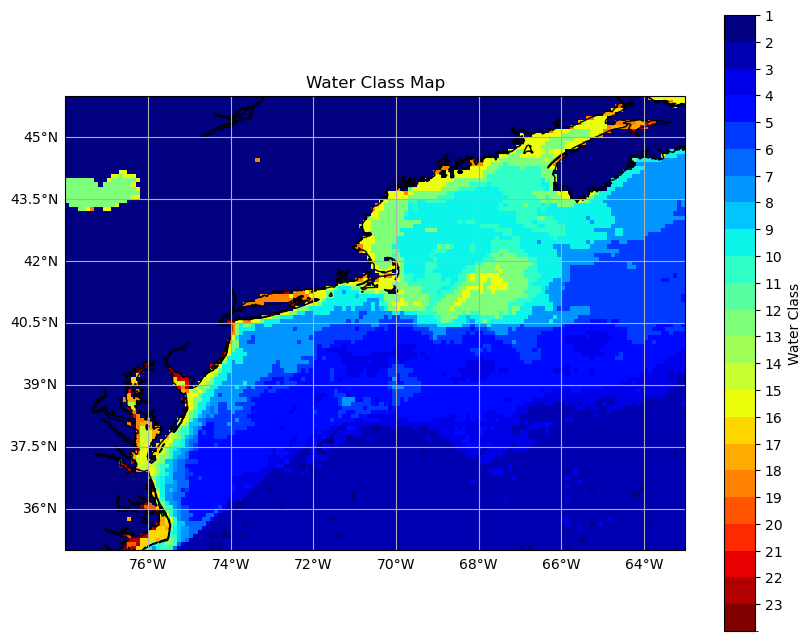

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm


plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define a colormap with 23 distinct colors (you can customize this list)
colors = plt.cm.jet(np.linspace(0, 1, 23))  # 23 colors from the 'viridis' colormap
cmap = ListedColormap(colors)

# Create a BoundaryNorm to discretize the colorbar and stretch it across all 23 classes
boundaries = np.arange(1, 25)  # 1 through 23, plus one extra boundary for the last class
norm = BoundaryNorm(boundaries, ncolors=23, clip=True)

# Plot the class_map with discretized colors
c = ax.pcolormesh(
    class_map.lon, class_map.lat, class_map,
    cmap=cmap, shading='auto', norm=norm
)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
cbar = plt.colorbar(c, ax=ax, label='Water Class')
cbar.set_ticks(np.arange(1, 24))  # Show ticks for whole numbers (1 through 23)
cbar.ax.invert_yaxis()  # Invert colorbar to match class order (if desired)
plt.title('Water Class Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## But what does it all mean?

Here, we're going to take the mean + std of all spectra that fall within each specific optical water class.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Reuse your class map color scheme
colors = plt.cm.jet(np.linspace(0, 1, 23))  # 23 class colors
cmap = ListedColormap(colors)
boundaries = np.arange(1, 25)
norm = BoundaryNorm(boundaries, ncolors=23, clip=True)


# Convert to NumPy arrays for safe masking
rrs_vals = rrs_flat.values  # shape (pixels, bands)
class_vals = class_flat.values  # shape (pixels,)

n_classes = 23
n_bands = rrs_vals.shape[1]
mean_spectra = np.full((n_classes, n_bands), np.nan)
std_spectra = np.full((n_classes, n_bands), np.nan)

for class_id in range(1, n_classes + 1):
    mask = (class_vals == class_id)
    if np.any(mask):
        spectra = rrs_vals[mask]  # shape (n_pixels_in_class, bands)
        mean_spectra[class_id - 1] = np.nanmean(spectra, axis=0)
        std_spectra[class_id - 1] = np.nanstd(spectra, axis=0)

## Comparing PACE data with reference data

Finally, we're going to compare the mean satellite data spectral shapes against the reference library. This is a bit of a sanity check, but also allows you to get an idea of the variance within each class. 

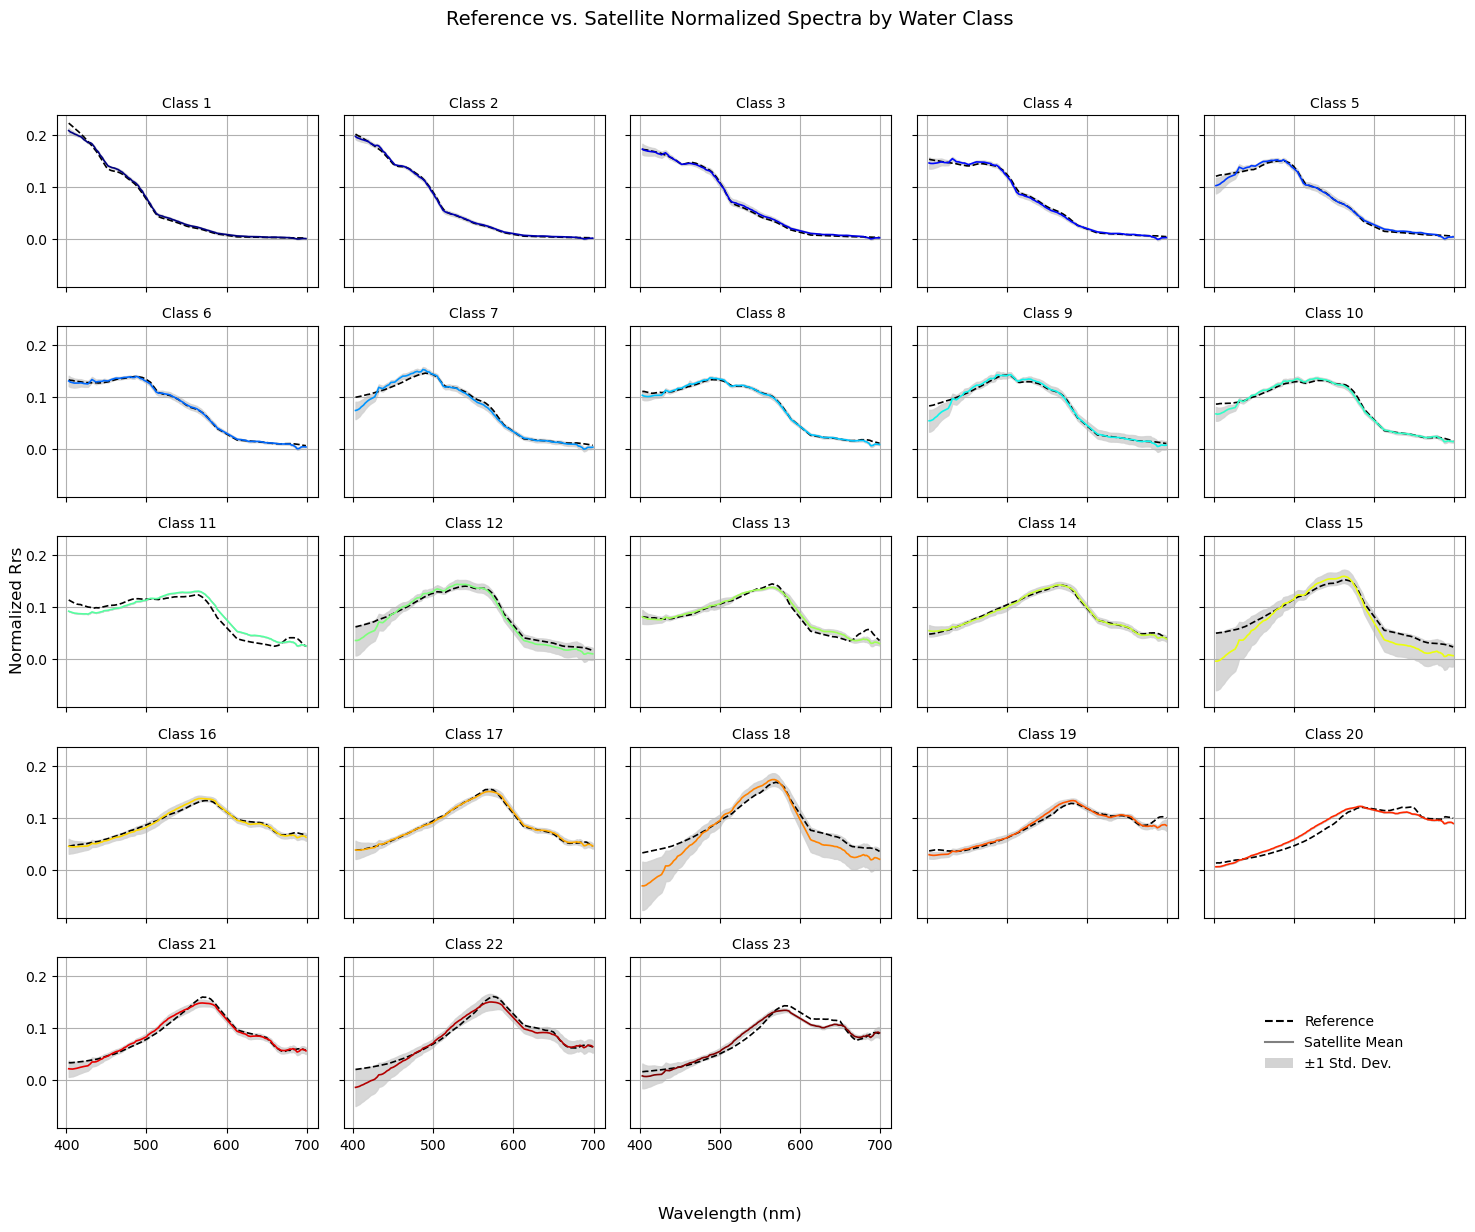

In [32]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

wavelengths_plot = np.array(common_wavelengths_float)

# Setup subplot grid
n_classes = 23
cols = 5
rows = int(np.ceil(n_classes / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting loop
for class_id in range(1, 24):
    ax = axes[class_id - 1]
    color = colors[class_id - 1]
    
    ref_spec = ref_norm[class_id - 1]
    sat_spec = mean_spectra[class_id - 1]
    sat_std = std_spectra[class_id - 1]
    
    if not np.any(np.isnan(sat_spec)):
        ax.fill_between(
            wavelengths_plot,
            sat_spec - sat_std,
            sat_spec + sat_std,
            color='lightgray',
            alpha=0.9,
            label='±1 Std. Dev.'
        )
    ax.plot(wavelengths_plot, ref_spec, '--', color='black', linewidth=1.2, label='Reference')
    ax.plot(wavelengths_plot, sat_spec, '-', color=color, linewidth=1.2, label='Satellite')

    ax.set_title(f'Class {class_id}', fontsize=10)
    ax.grid(True)
    ax.label_outer()

# Remove unused subplots and use one for legend
for i in range(n_classes, len(axes)):
    fig.delaxes(axes[i])

# Create a dummy legend in the bottom-right corner (last empty subplot position)
legend_ax = fig.add_subplot(rows, cols, cols * rows)  # last cell
legend_ax.axis('off')  # Hide axis

# Legend elements
legend_lines = [
    Line2D([0], [0], linestyle='--', color='black', label='Reference'),
    Line2D([0], [0], linestyle='-', color='gray', label='Satellite Mean'),
    Patch(facecolor='lightgray', edgecolor='none', label='±1 Std. Dev.')
]

legend_ax.legend(handles=legend_lines, loc='center', fontsize=10, frameon=False)

# Global labels
fig.suptitle("Reference vs. Satellite Normalized Spectra by Water Class", fontsize=14)
fig.supxlabel("Wavelength (nm)")
fig.supylabel("Normalized Rrs")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


There you have it! You are now an OWT expert. You are now entitled to cut to the front of the line in all ocean color related events. You may raise your chin high and look down from your perch of wisdom to the others who do not possess the power of OWTs. Enjoy the rest of your day, majesty. 